In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
! cp -r /kaggle/input/erav1-s18-vae/VAE/ /kaggle/working/

In [43]:
from src.models import VAE, CIFAR_Encoder, CIFAR_Decoder
import pytorch_lightning as pl

In [44]:
import torch
encoder = CIFAR_Encoder(latent_dim=512)
decoder = CIFAR_Decoder(latent_dim=512)
model = VAE(encoder, decoder, enc_out_dim=512, latent_dim=512, lamda_label_loss=300)
model.decoder_classifier.linear = torch.nn.Linear(512, 10)
model.decoder_classifier.load_state_dict(torch.load('store/cifar10_encoder.pt',))

<All keys matched successfully>

In [45]:
model

VAE(
  (encoder): CIFAR_Encoder(
    (prep_layer): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
    )
    (l1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Dropout(p=0.1, inplace=False)
    )
    (l1res): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, 

In [46]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Train data transformations
train_transforms = A.Compose(
    [
#         A.PadIfNeeded(min_height=48, min_width=48, always_apply=True, border_mode=0),
#         A.RandomCrop(height=32, width=32, always_apply=True),
        A.HorizontalFlip(p=0.5),
        A.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ToTensorV2(),
    ]
)

# Test data transformations
test_transforms = A.Compose(
    [
        A.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ToTensorV2(),
    ]
)


In [47]:
from src.datasets import CIFAR10DataModule
cifar_dm = CIFAR10DataModule(train_transforms, test_transforms, num_workers=2)

In [48]:
pl.seed_everything(1234)

trainer = pl.Trainer( max_epochs=30, callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=20)], gradient_clip_val=0.5)

In [49]:
from pytorch_lightning.tuner import Tuner

tuner = Tuner(trainer=trainer)

# Run learning rate finder
lr_finder = tuner.lr_find(model,datamodule=cifar_dm, min_lr=1e-4, max_lr=1e-1, num_training=300)

Files already downloaded and verified
Files already downloaded and verified


Finding best initial lr:   0%|          | 0/300 [00:00<?, ?it/s]

new_lr=0.00012882495516931342


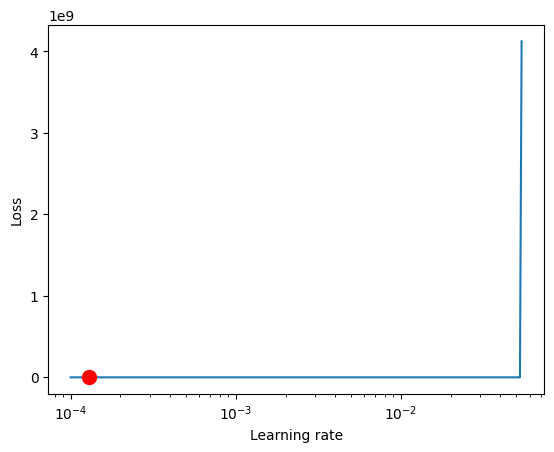

In [50]:
# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print(f"{new_lr=}")

In [51]:
model.best_lr = 3e-4
trainer.fit(model, cifar_dm)

Files already downloaded and verified
Files already downloaded and verified


Training: 0it [00:00, ?it/s]

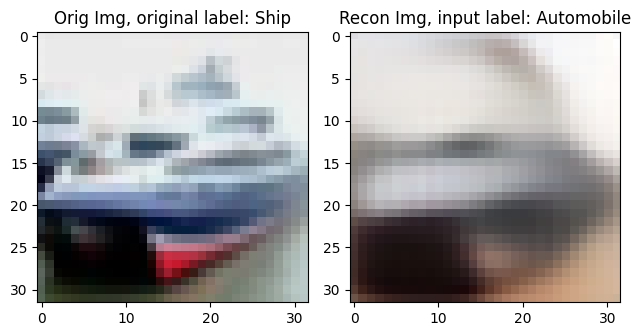

In [52]:
model.plot_single_test_cifar(1, 1)

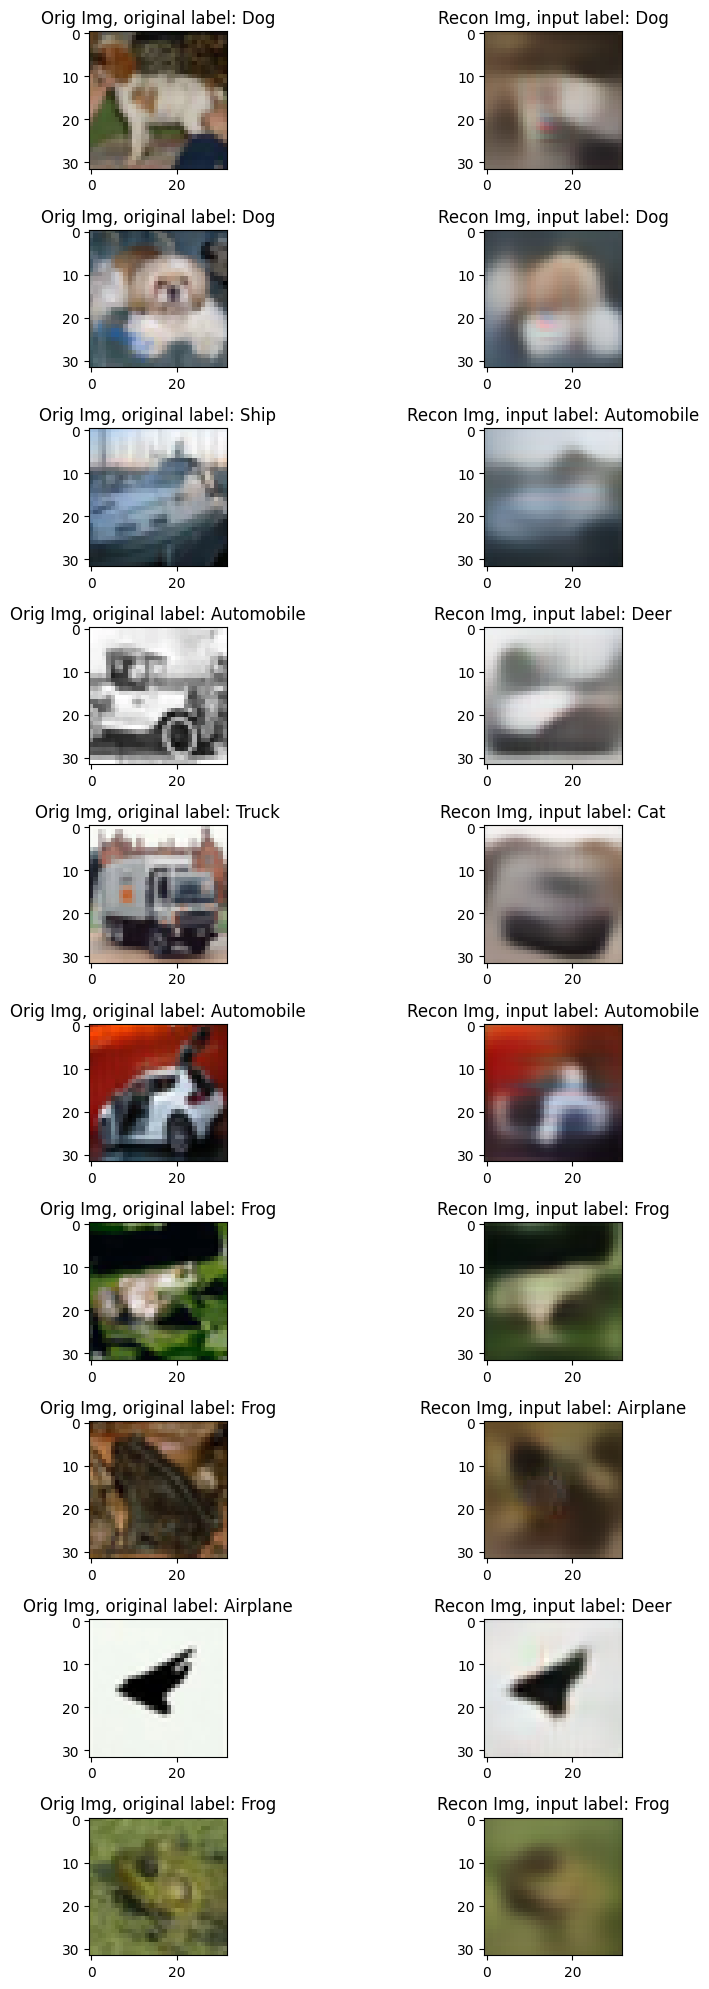

In [53]:
model.plot_test_cifar(10)

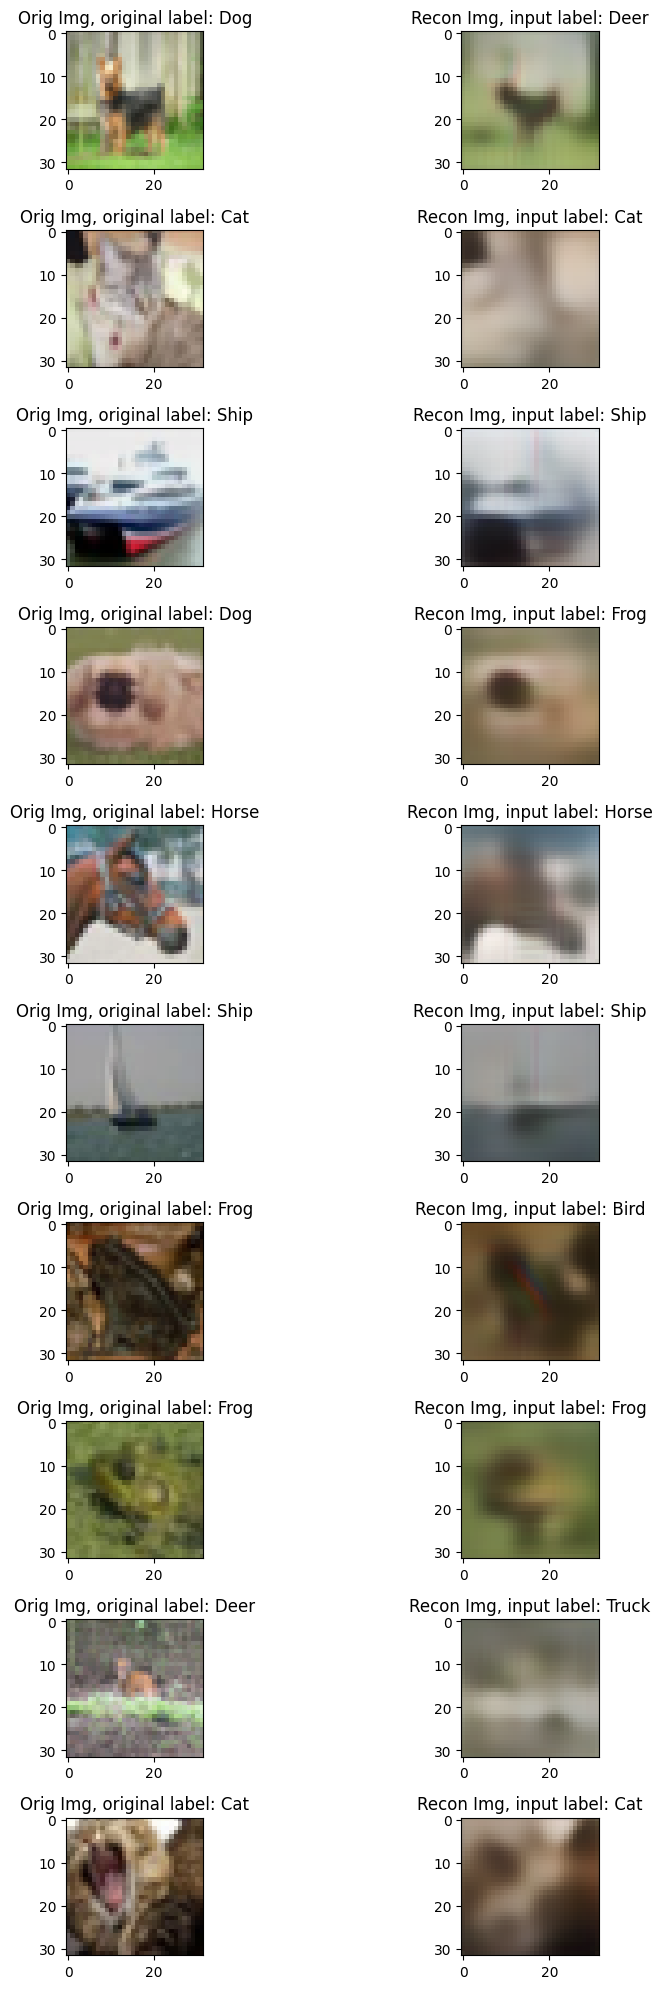

In [54]:
model.plot_test_cifar(10)

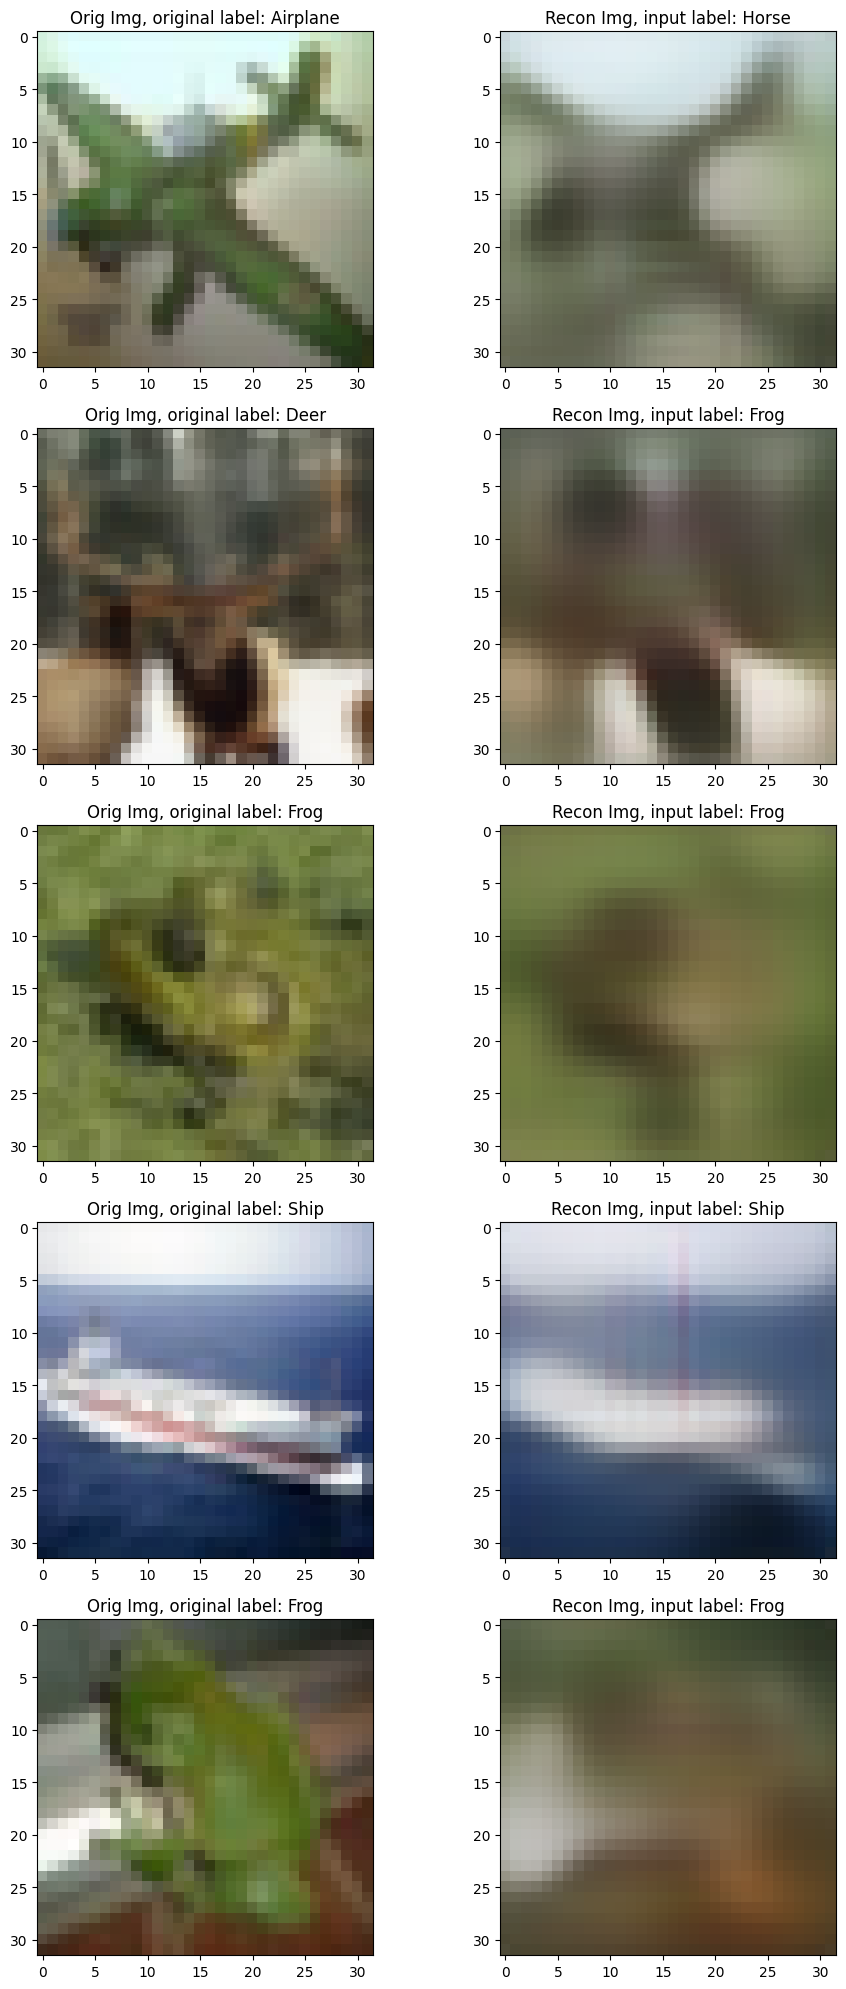

In [55]:
model.plot_test_cifar(5)